In [1]:
# import resources
%matplotlib inline

import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms as T, models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODELS = {'vgg19': {'model_init': models.vgg19, 'rep_layers':[0, 5, 10, 19, 21, 28]}}

/homes/iws/lpremc/miniconda3/envs/cse490g1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Neural Style Transfer

## Background

### Content Loss
$L_{\text{content}} = \sum_{i, j, k} (F^l_{ijk} - P^l_{ijk})^2$

### Style Loss
**Gram Matrix for Style Representation**

$G^l_{ij} = \sum_{k} F_{ik}^l F_{jk}^l$ where $i, j$ = pixel's position, $k$ = filter

$L_{\text{style}}^l = \frac{1}{K_l H_l W_l}\sum_{i, j} (G^l_{ij} - A^l_{ij})^2$

$L_{\text{style}} = \sum_l w_l L_{\text{style}}^l$

$L_{\text{total}} = \alpha L_{\text{content}} + \beta L_{\text{style}}$

## Results and Experiments

### Initializing a target image with random noise vs. a copy of the original image 

### Effect of $\beta$ to the generated image


In [2]:
model_name = 'vgg19'
model = MODELS[model_name]['model_init'](pretrained=True).to(device)
layers = MODELS[model_name]['rep_layers']

for param in model.parameters():
    param.requires_grad_(False)

/homes/iws/lpremc/miniconda3/envs/cse490g1/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/homes/iws/lpremc/miniconda3/envs/cse490g1/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def load_image(img_path, size=600, shape=None):
    image = Image.open(img_path).convert('RGB')
    if shape is not None:
        size = shape
    transformation = T.Compose([T.Resize(size), T.ToTensor()])
    image = transformation(image).unsqueeze(0)
    return image

def to_numpy(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    return image

def get_features(x):
    features = []
    for name, layer in model.features._modules.items():
        x = layer(x)
        features.append(x)
    return [features[i] for i in layers]

In [4]:
content = load_image('imgs/style1.jpg').to(device)
for x in get_features(content):
    print(x.shape)

torch.Size([1, 64, 600, 809])
torch.Size([1, 128, 300, 404])
torch.Size([1, 256, 150, 202])
torch.Size([1, 512, 75, 101])
torch.Size([1, 512, 75, 101])
torch.Size([1, 512, 37, 50])


In [4]:
mse_loss = nn.MSELoss()

style_weights = [1, 0.8, 0.5, 0.3, 0.1, 0]

def compute_gram(x):
    _, d, w, h = x.shape
    x = x.view(d, h*w)
    return torch.mm(x, x.t())
    
def content_loss(content_features, target_features):
  return mse_loss(target_features[-3], content_features[-3])    

def style_loss(style_features, target_features):
  loss = 0
  for i in range(len(target_features)):
    target_feature = target_features[i]
    _, d, h, w = target_feature.shape
    
    target_gram = compute_gram(target_features[i])
    style_gram = compute_gram(style_features[i])

    loss += style_weights[i] * mse_loss(target_gram, style_gram) / (d * h * w)
  return loss

def total_variation_loss(x):      
      tv_h = (x[:,:,1:,:] - x[:,:,:-1,:]).pow(2).sum()
      tv_w = (x[:,:,:,1:] - x[:,:,:,:-1]).pow(2).sum()    
      return tv_h + tv_w

In [5]:
def style_transfer(content, style, epoch, lr=0.03, style_weight=0.1, tv_weight=1e-3, random_noise=False, show_every=1000):
  fig, ax = plt.subplots(1, 3, figsize=(25, 10))
  losses = []
  targets = []
  # initialize random noise
  target = content.clone().to(device).requires_grad_(True)
  if random_noise:
    target = torch.rand(content.shape).to(device).requires_grad_(True)
  optimizer = optim.Adam([target], lr)
  t = tqdm(range(0, epoch))
  grayscale = T.Grayscale(3)
  content_features = get_features(content)
  style_features = get_features(style)
  for it in t:
      c_loss = content_loss(content_features, get_features(target))
      s_loss = style_weight * style_loss(style_features, get_features(target))
      tv_loss = tv_weight * total_variation_loss(target)
      loss = c_loss + s_loss + tv_loss
      losses.append(loss.item())
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  ax[0].axis('off')
  ax[0].imshow(to_numpy(content))
  ax[1].axis('off')
  ax[1].imshow(to_numpy(style))
  ax[2].axis('off')
  ax[2].imshow(to_numpy(target))
  fig.show()
  return target, losses 

100%|██████████| 3000/3000 [01:04<00:00, 46.17it/s]


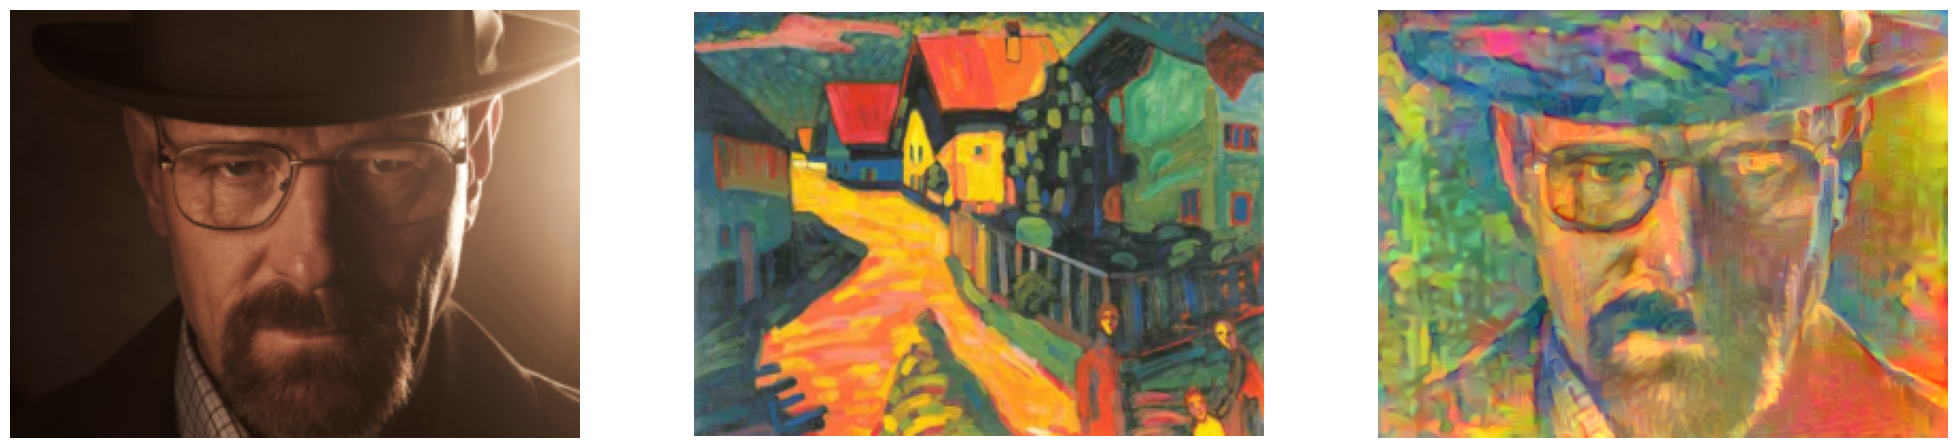

In [32]:
content = load_image(f'imgs/pic6.jpg', size=200).to(device)
style = load_image(f'imgs/style1.jpg', size=200).to(device)
for style_weight in [3]:
    target, loss = style_transfer(content, style, 3000, lr=0.03, style_weight=style_weight, tv_weight=1e-3, random_noise=True)

100%|██████████| 3000/3000 [01:05<00:00, 46.09it/s]


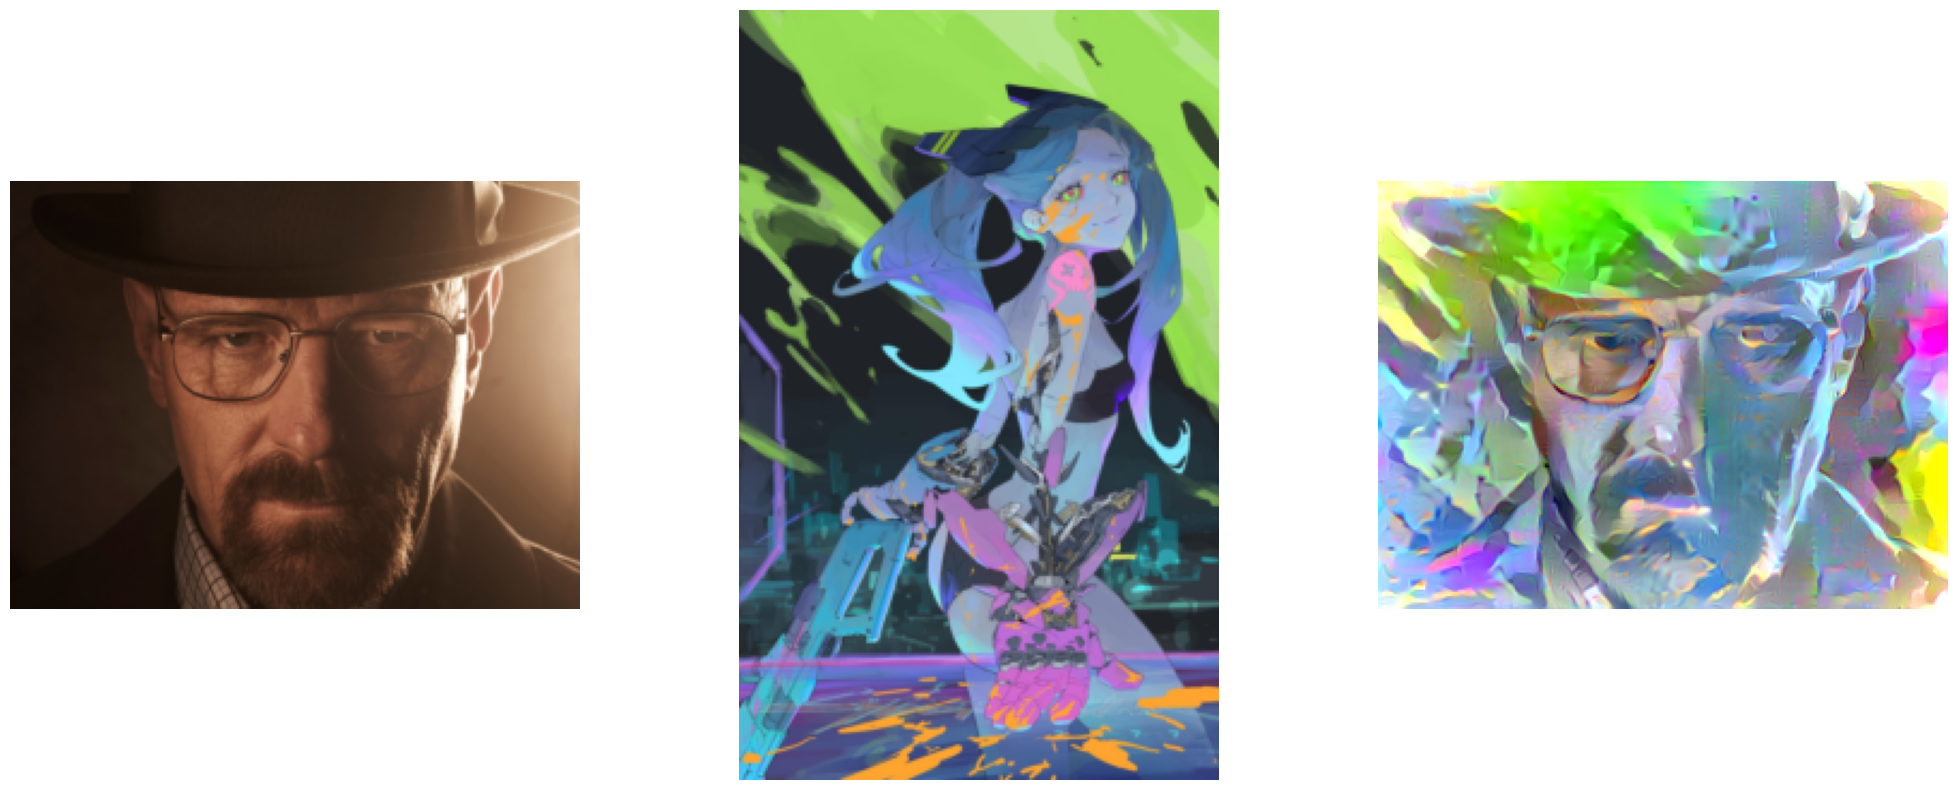

In [37]:
content = load_image(f'imgs/pic6.jpg', size=200).to(device)
style = load_image(f'imgs/pic1.jpg', size=200).to(device)
for style_weight in [2]:
    target, loss = style_transfer(content, style, 3000, lr=0.03, style_weight=style_weight, tv_weight=1e-3, random_noise=True)

100%|██████████| 3000/3000 [01:07<00:00, 44.56it/s]


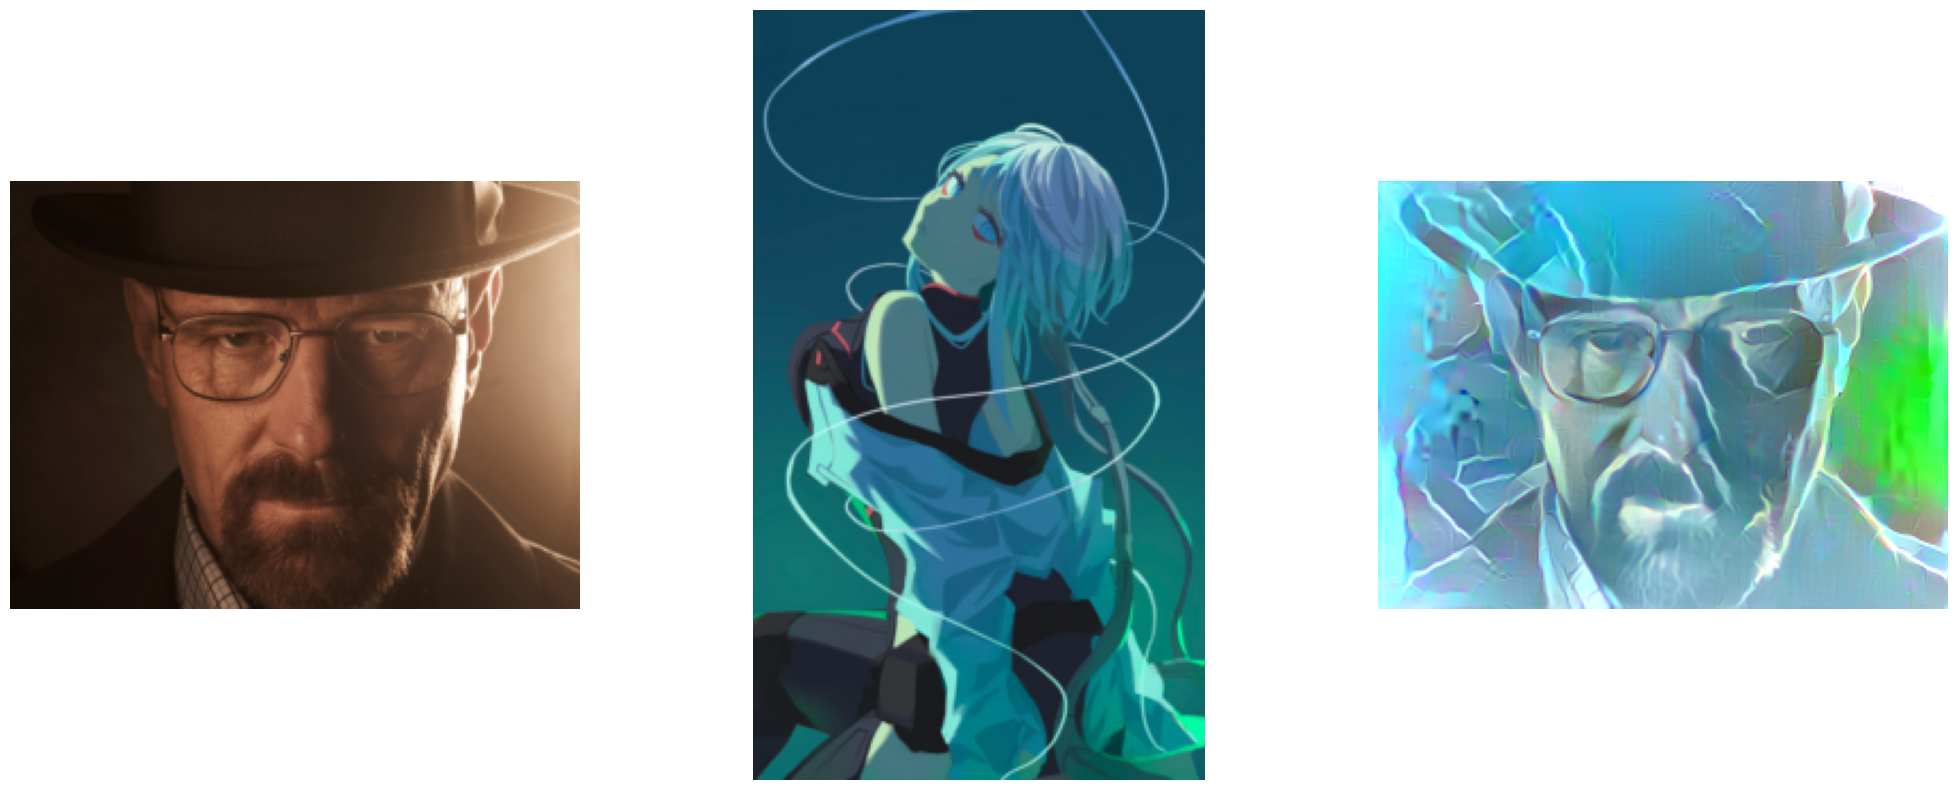

In [38]:
content = load_image(f'imgs/pic6.jpg', size=200).to(device)
style = load_image(f'imgs/pic5.jpg', size=200).to(device)
for style_weight in [2]:
    target, loss = style_transfer(content, style, 3000, lr=0.03, style_weight=style_weight, tv_weight=1e-3, random_noise=True)

100%|██████████| 3000/3000 [01:05<00:00, 45.76it/s]


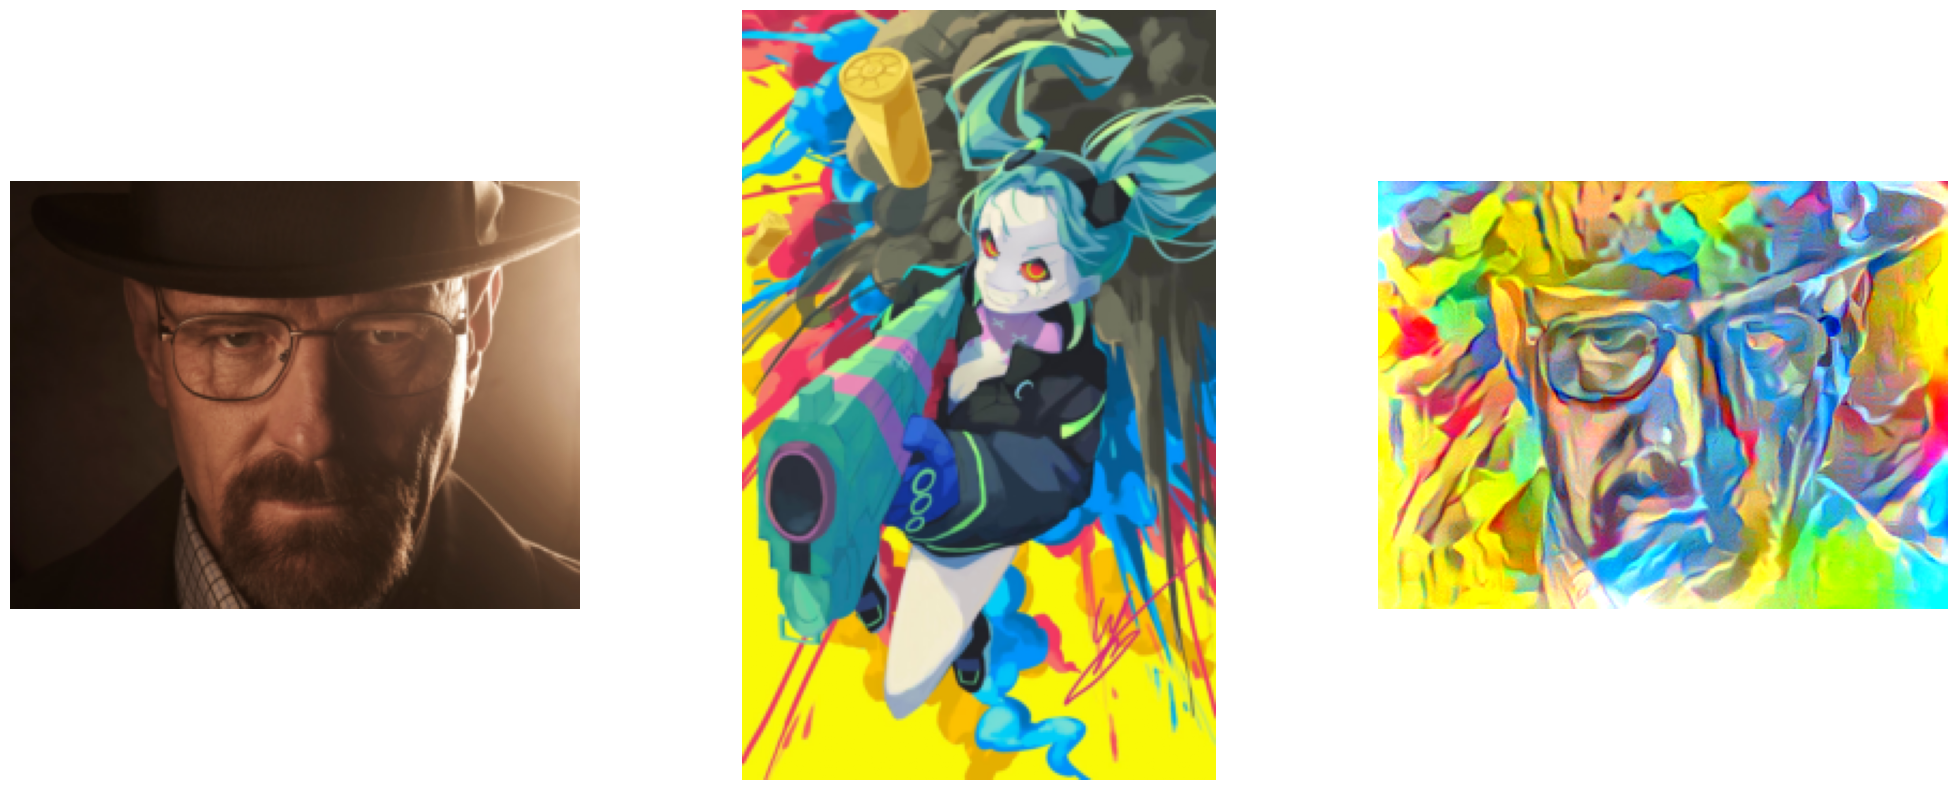

In [39]:
content = load_image(f'imgs/pic6.jpg', size=200).to(device)
style = load_image(f'imgs/pic4.jpg', size=200).to(device)
for style_weight in [2]:
    target, loss = style_transfer(content, style, 3000, lr=0.03, style_weight=style_weight, tv_weight=1e-3, random_noise=True)

100%|██████████| 5000/5000 [01:50<00:00, 45.44it/s]


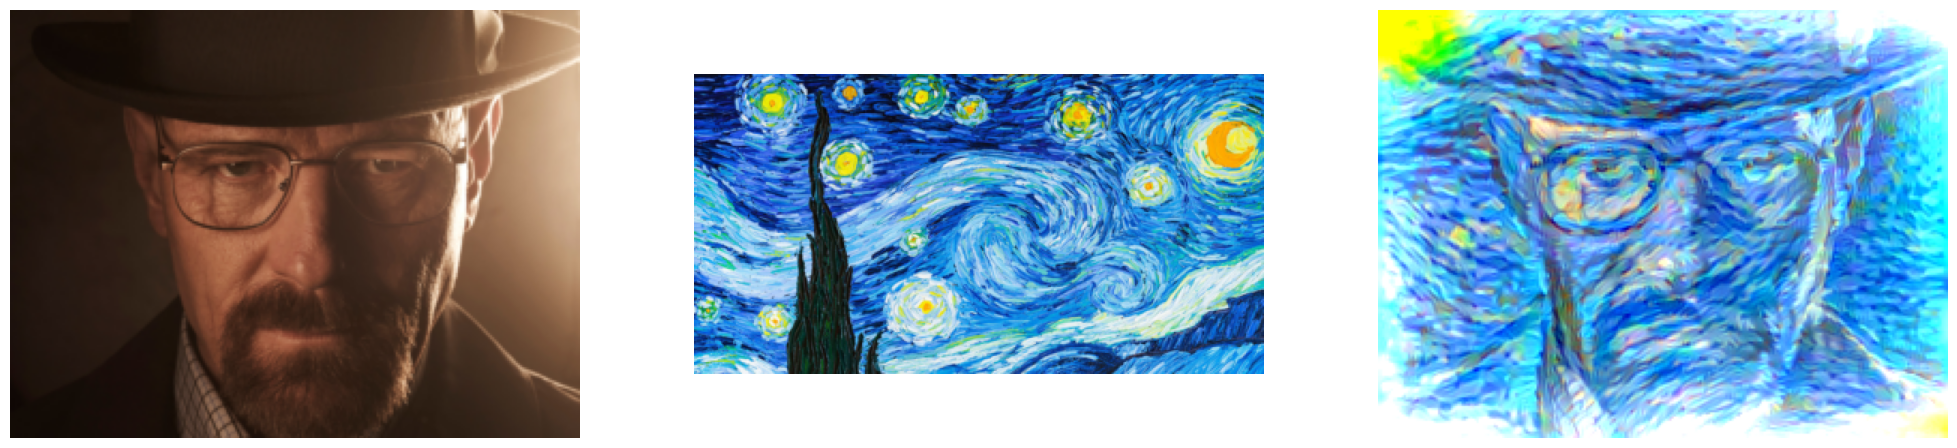

In [29]:
content = load_image(f'imgs/pic6.jpg', size=200).to(device)
style = load_image(f'imgs/style5.jpg', size=200).to(device)
for style_weight in [1.5]:
    target, loss = style_transfer(content, style, 3000, lr=0.03, style_weight=style_weight, tv_weight=1e-3, random_noise=True)